In [ ]:
# Do not run it
!unzip /content/drive/MyDrive/entra/ODIR-5K_augmentationfile.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training Images/3160_right-N.jpg  
  inflating: Training Images/3162_right-N.jpg  
  inflating: Training Images/3163_left-N.jpg  
  inflating: Training Images/3163_right-N.jpg  
  inflating: Training Images/3164_right-N.jpg  
  inflating: Training Images/3165_left-N.jpg  
  inflating: Training Images/3166_left-N.jpg  
  inflating: Training Images/3166_right-N.jpg  
  inflating: Training Images/3167_left-N.jpg  
  inflating: Training Images/3167_right-N.jpg  
  inflating: Training Images/3168_left-N.jpg  
  inflating: Training Images/3168_right-N.jpg  
  inflating: Training Images/3169_left-N.jpg  
  inflating: Training Images/3169_right-N.jpg  
  inflating: Training Images/316_left-O.jpg  
  inflating: Training Images/316_leftVF-O.jpg  
  inflating: Training Images/316_right-O.jpg  
  inflating: Training Images/316_rightVF-O.jpg  
  inflating: Training Images/3170_right-N.jpg  
  inflating: Training Images/3171_left-N.jpg 

In [ ]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random



In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [ ]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_images/*.jpg")

In [ ]:
def get_label(name):
    parts = tf.strings.split(name, sep="-")
    label = tf.strings.split(parts[-1], sep=".")
    label = tf.strings.bytes_split(label[0])
    l = [0, 0, 0, 0, 0, 0, 0, 0]
    for e in label:
        if e != '&' and e != 'X':
            if e == 'N':
                l[0] = 1
            elif e == 'D':
                l[1] = 1
            elif e == 'G':
                l[2] = 1
            elif e == 'C':
                l[3] = 1
            elif e == 'A':
                l[4] = 1
            elif e == 'H':
                l[5] = 1
            elif e == 'M':
                l[6] = 1
            elif e == 'O':
                l[7] = 1
    return l

def get_name(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-1]

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    #img = tf.image.adjust_contrast(img, 2)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
    return img

def process_path(file_path):
    name = get_name(file_path)
    label = get_label(name)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(250, 250, 3)
label:  N [1 0 0 0 0 0 0 0]
(250, 250, 3)
label:  G [0 0 1 0 0 0 0 0]
(250, 250, 3)
label:  D [0 1 0 0 0 0 0 0]
(250, 250, 3)
label:  N [1 0 0 0 0 0 0 0]
(250, 250, 3)
label:  N [1 0 0 0 0 0 0 0]
(250, 250, 3)
label:  G [0 0 1 0 0 0 0 0]


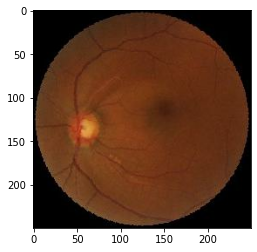

In [ ]:
for image, label in resampled_named_ds.take(6):
    print(image.shape)
    plt.imshow(image.numpy())
    print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [ ]:
def randomly_augment(image,label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    ds = ds.cache()
    ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
    ds = ds.repeat()

    return ds

In [ ]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=1000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[1 0 0 0 0 0 0 0]


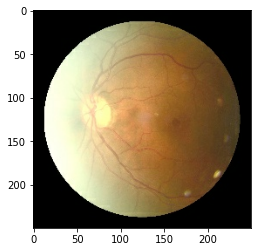

In [ ]:
for example in final_train_ds.take(1):
    image, label = example
    break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [ ]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(64, (2, 2), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.2),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (2, 2), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(150, (2, 2), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'sigmoid')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 64)      192       
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 83, 83, 64)        0

In [ ]:
history_cnn = model_cnn.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=15,
                    steps_per_epoch = 450, #train_elements/batch_size
                    validation_data=final_test_ds.repeat(),
                    validation_steps = 60,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/15
450/450 [==============================] - 374s 831ms/step - loss: 0.1485 - accuracy: 0.7869 - precision: 0.7945 - recall: 0.7025 - val_loss: 0.3830 - val_accuracy: 0.3922 - val_precision: 0.4450 - val_recall: 0.2820
Epoch 2/15
450/450 [==============================] - 115s 256ms/step - loss: 0.1449 - accuracy: 0.8008 - precision: 0.8036 - recall: 0.7124 - val_loss: 0.3983 - val_accuracy: 0.4333 - val_precision: 0.4003 - val_recall: 0.4727
Epoch 3/15
450/450 [==============================] - 352s 783ms/step - loss: 0.1397 - accuracy: 0.8018 - precision: 0.8067 - recall: 0.7201 - val_loss: 0.4070 - val_accuracy: 0.4328 - val_precision: 0.4318 - val_recall: 0.4198
Epoch 4/15
450/450 [==============================] - 125s 278ms/step - loss: 0.1400 - accuracy: 0.8030 - precision: 0.8078 - recall: 0.7235 - val_loss: 0.3964 - val_accuracy: 0.4245 - val_precision: 0.4174 - val_recall: 0.3857
Epoch 5/15
450/450 [==============================] - 353s 785ms/step - loss: 0.1302 - a

In [ ]:
history_cnn1 = model_cnn.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=2,
                    steps_per_epoch = 450, #train_elements/batch_size
                    validation_data=final_test_ds.repeat(),
                    validation_steps = 60,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/2
450/450 [==============================] - 302s 671ms/step - loss: 0.0991 - accuracy: 0.8647 - precision: 0.8632 - recall: 0.8069 - val_loss: 0.4816 - val_accuracy: 0.4505 - val_precision: 0.4286 - val_recall: 0.4783
Epoch 2/2
450/450 [==============================] - 200s 444ms/step - loss: 0.0989 - accuracy: 0.8699 - precision: 0.8644 - recall: 0.8103 - val_loss: 0.4622 - val_accuracy: 0.4281 - val_precision: 0.4322 - val_recall: 0.3806


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [ ]:
model_cnn.save('ocular_disease_model1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ocular_disease_model1/assets


In [ ]:
# Do not run it
!zip -r ocular_disease_model1.zip ocular_disease_model1

  adding: ocular_disease_model1/ (stored 0%)
  adding: ocular_disease_model1/variables/ (stored 0%)
  adding: ocular_disease_model1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: ocular_disease_model1/variables/variables.index (deflated 69%)
  adding: ocular_disease_model1/saved_model.pb (deflated 90%)
  adding: ocular_disease_model1/assets/ (stored 0%)


In [ ]:
# Do not run it in jupyter notebook
!cp -r ocular_disease_model1.zip /content/drive/MyDrive/entra

In [ ]:
from tensorflow import keras
model = keras.models.load_model('model.h5')

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0
